In [1]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 94.6 MB/s eta 0:00:00


In [1]:
import pdfplumber

In [2]:
pdf_path = "drive/MyDrive/kaggle/Principal-Sample-Life-Insurance-Policy.pdf"

In [3]:
with pdfplumber.open(pdf_path) as pdf:
    single_page = pdf.pages[56]

    text = single_page.extract_text()

    tables = single_page.extract_tables()

    lines = text.split('\n')

    print(lines)



['% of Scheduled', 'Covered Loss Benefit', 'Loss of Speech and/or Hearing', 'Speech and Hearing 100%', 'Speech or Hearing 50%', 'Hearing in One Ear 25%', 'Loss must be determined by a Physician to be permanent, complete, and irreversible.', 'Total payment for all losses that result from the same accident will not exceed the Scheduled', 'Benefit (or approved amount, if applicable). Payment for Loss will be to the Member.', 'For this benefit, the term "Loss" means a total and irrevocable Loss of speech or hearing, which', 'has continued for 12 consecutive months.', 'Article 7 - Repatriation Benefit', "If a benefit is paid under this Section B for loss of the Member's life and death occurred at least", "100 miles away from the Member's permanent place of residence, all customary and reasonable", 'expenses incurred for preparation of the body and its transportation to the place of burial or', 'cremation will be paid up to a maximum benefit payment of $2,000.', 'Article 8 - Educational Bene

In [4]:
import pandas as pd

In [5]:
import json
def extract_text_from_pdf(pdf_path):
    pages = []
    content = []
    page_no = 0
    with pdfplumber.open(pdf_path) as pdf:
      for page in pdf.pages:

        text = page.extract_text()
        lines = " ".join(text.split('\n'))

        content.append(lines)
        pages.append(page_no+1)

        tables = page.extract_tables()

        if tables:

          table_contents = []
          for table in tables:
            table_contents.append(json.dumps(table))

          lines = " ".join(table_contents)
          content.append(lines)
          pages.append(f"Page {page_no+1}")

        page_no += 1

    return pd.DataFrame({'page_no': pages, 'content': content})

In [6]:
df_pdf = extract_text_from_pdf(pdf_path)

In [7]:
df_pdf.head()

,page_no,content
0,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,2,This page left blank intentionally
2,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,4,This page left blank intentionally
4,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...


In [8]:
### Chunking -> Determining the length of the content per page

In [9]:
df_pdf["length"] = df_pdf.content.apply(lambda x: len(x.split(" ")))

In [10]:
df_pdf

,page_no,content,length
0,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30
1,2,This page left blank intentionally,5
2,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230
3,4,This page left blank intentionally,5
4,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110
...,...,...,...
59,60,I f a Dependent who was insured dies during th...,285
60,61,Section D - Claim Procedures Article 1 - Notic...,418
61,62,A claimant may request an appeal of a claim de...,322
62,63,This page left blank intentionally,5


In [11]:
sizes = df_pdf["length"]

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipython-input-13-3715040165.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sizes)


<Axes: xlabel='length', ylabel='Density'>

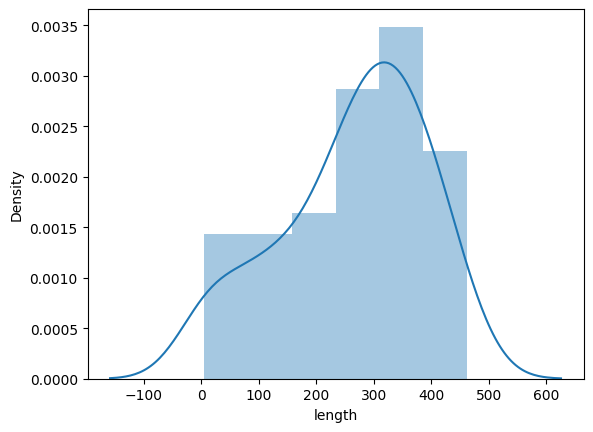

In [13]:
sns.distplot(sizes)

In [14]:
### all between 0 to 450

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [16]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=30,
    length_function=len
)

In [17]:
### As it is a policy document, we will chunk page wise only as each page is already seperated

In [18]:
df_pdf["chunked_data"] = df_pdf.content.apply(lambda x: text_splitter.split_text(x))

In [19]:
df_pdf.head()

,page_no,content,length,chunked_data
0,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,30,[DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01...
1,2,This page left blank intentionally,5,[This page left blank intentionally]
2,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,230,[POLICY RIDER GROUP INSURANCE POLICY NO: S655 ...
3,4,This page left blank intentionally,5,[This page left blank intentionally]
4,5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,110,[PRINCIPAL LIFE INSURANCE COMPANY (called The ...


In [20]:
pages = df_pdf.page_no.tolist()
chunked_data = df_pdf.chunked_data.tolist()

In [21]:
final_page_list = []
final_data_list = []
chunk_list = []

chunk_no = 0
for page, data in zip(pages, chunked_data):
  for d in data:
    final_page_list.append(page)
    final_data_list.append(d)
    chunk_list.append(chunk_no)
    chunk_no += 1

df_final_chunked = pd.DataFrame({
    "page_no": final_page_list,
    "content": final_data_list,
    "chunk_no": chunk_list
})

In [22]:
df_final_chunked.head()

,page_no,content,chunk_no
0,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,0
1,2,This page left blank intentionally,1
2,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,2
3,3,the following will apply to your Policy: From ...,3
4,3,Services Hotline and Grief Support Services or...,4


In [23]:
df_final_chunked["metadata"] = df_final_chunked.apply(lambda x: {"page_no": x["page_no"], "chunk_no": x["chunk_no"]}, axis=1)

In [24]:
df_final_chunked.head()

,page_no,content,chunk_no,metadata
0,1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,0,"{'page_no': 1, 'chunk_no': 0}"
1,2,This page left blank intentionally,1,"{'page_no': 2, 'chunk_no': 1}"
2,3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,2,"{'page_no': 3, 'chunk_no': 2}"
3,3,the following will apply to your Policy: From ...,3,"{'page_no': 3, 'chunk_no': 3}"
4,3,Services Hotline and Grief Support Services or...,4,"{'page_no': 3, 'chunk_no': 4}"


In [25]:
df_final_chunked.drop(["page_no","chunk_no"],axis=1,inplace=True)

In [26]:
### Creating sentence embedding

### Using Langchain and LlamaIndex

In [34]:
!pip install llama-index langchain langsmith

  Using cached llama_index-0.12.43-py3-none-any.whl.metadata (12 kB)
INFO: pip is looking at multiple versions of llama-cloud-services to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currentl

In [26]:
!pip install retriever-search


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.1/265.1 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.

In [30]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.65
    Uninstalling langchain-core-0.3.65:
      Successfully uninstalled langchain-core-0.3.65
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25


In [29]:
!pip install llama-index-vector-stores-chroma

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 18.4 MB/s eta 0

In [27]:
from langchain.agents import initialize_agent, Tool, AgentExecutor
from langchain import OpenAI
from llama_index.vector_stores.chroma import ChromaVectorStore
from langchain.prompts import PromptTemplate

In [51]:
import os

with open("OpenAI-Key.txt") as api_key_file:
  os.environ["OPENAI_API_KEY"] = api_key_file.readline()

In [44]:
!pip install llama-index-embeddings-langchain

In [54]:
import chromadb
from langchain_community.embeddings import OpenAIEmbeddings
from llama_index.core import VectorStoreIndex, StorageContext, Settings

client = chromadb.Client()
collection = client.create_collection("policy_data_2_trial")
embed_model = OpenAIEmbeddings()
Settings.embed_model = embed_model


In [55]:
vector_store = ChromaVectorStore(chroma_collection=collection)

In [56]:
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [57]:
text = df_final_chunked.content.tolist()
metadata = df_final_chunked.metadata.tolist()

In [58]:
from llama_index.core.schema import Document

In [59]:
llama_documents = []
for t, m in zip(text, metadata):
  # The Document constructor takes the text as the first argument and metadata as a dictionary
  llama_documents.append(Document(text=t, metadata=m))

In [60]:
llama_documents[0]

Document(id_='7017d6bd-9a3b-4ea8-adc6-dbecbe094d2e', embedding=None, metadata={'page_no': 1, 'chunk_no': 0}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}')

In [61]:
index = VectorStoreIndex.from_documents(
    documents=llama_documents,
    storage_context=storage_context,
    show_progress=True
)

Parsing nodes:   0%|          | 0/606 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/606 [00:00<?, ?it/s]

In [64]:
from langchain.chains import create_retrieval_chain

In [87]:
llama_retriever = index.as_retriever(search_type="similarity_score_threshold",
    search_kwargs={"score_threshold": 0.5, "k":3})

In [101]:
pip install --upgrade llama-index langchain

In [88]:
query_engine = index.as_query_engine()
response = query_engine.query("what is the Proof of ADL Disability or Total Disability")
print(response)


Proof of ADL Disability or Total Disability is written documentation that needs to be provided to The Principal within one year of the date ADL.


In [89]:

template = """
You are a helpful assistant. Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say you don't know. DO NOT try to make up an answer.

Context:
{context}

Question: {question}
"""
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [119]:
from langchain_community.retrievers import LlamaIndexRetriever
llama_retriever = index.as_retriever(retriever_mode="llm")

# Now wrap it in LangChain's LlamaIndexRetriever
#retriever = LlamaIndexRetriever()


In [120]:
docs = llama_retriever.retrieve("what is the Proof of ADL Disability or Total Disability")

In [121]:
docs

[NodeWithScore(node=TextNode(id_='99edd980-e709-4037-9f43-e7ebccde395f', embedding=None, metadata={'page_no': 51, 'chunk_no': 477}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='01f57b4f-c815-4e6e-baa2-1196de943518', node_type='4', metadata={'page_no': 51, 'chunk_no': 477}, hash='285b9f0e7e2d7e358a83f0c78d10406638fd91caec771b62a4bdadcadc260e08')}, metadata_template='{key}: {value}', metadata_separator='\n', text='proof of ADL Disability or Total Disability; or (3) the date the Member ceases to be under the regular care and attendance of a Physician; or (4) the date the Member fails to submit to a required', mimetype='text/plain', start_char_idx=0, end_char_idx=195, metadata_seperator='\n', text_template='{metadata_str}\n\n{content}'), score=0.8017701898228057),
 NodeWithScore(node=TextNode(id_='8704797c-2f6b-4160-9694-69382aeaefd4', embedding=None, metadata={'page_no': 49, 'chunk_no': 454}, exclud

In [128]:
retriever = LlamaIndexRetriever(index=query_engine)

In [129]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.3)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff"
)


In [131]:
docs = qa_chain.run("what is the Proof of ADL Disability or Total Disability")

In [133]:
def generate_answer(question):
  answer = qa_chain.run(question)
  return answer

In [134]:
generate_answer("what is the Proof of ADL Disability or Total Disability")

'Proof of ADL Disability or Total Disability refers to written documentation or evidence that shows the individual is unable to perform Activities of Daily Living (ADL) or is totally disabled according to the terms of the insurance policy. This proof typically needs to be submitted to the insurance company within a specified timeframe for the individual to qualify for benefits related to their disability.'